# Шаблон для проекта по A/B - тестам.

### `chat_id ` из Телеграма:

In [34]:
446110916

446110916

------------------

##  <ins>Задание 1.</ins>

### 0. Запосить у бота в Телеграме условие командой `/get_project1_desc`.

**Контекст**

В связи с постановлением Центрального Банка
наше текущее содержание диалога с клиентом (скрипт)
операторов считается слишком жёстким,
и нам нужно придумать более мягкий скрипт,
который будет всё ещё иметь хорошие показатели.
У нас есть два варианта более мягкого скрипта,
и мы хотим выбрать лучший из них.
При этом у нас нет времени 
чтобы ждать вызревания долгих метрик вроде PV.
        
**Тест**

Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где одной части мы продаём одним вариантом скрипта,
другой - другим.
Целью этого теста
является поиск наилучшего скрипта.

**Статистические вводные**

Уровень значимости 5%.
Мы хотели бы различать 8%-ное
изменение целевой метрики
с вероятностью 80%.

Значит, **alpha** = 0.05
**Lift** = 0.08
**beta** = 0.20

Посмотрим датасет

In [35]:
import pandas as pd
from scipy.stats import norm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import math
import io

In [36]:
from google.colab import files
uploaded = files.upload()

Saving hist_telesales.csv to hist_telesales.csv


In [37]:
import io
hist_data = pd.read_csv(io.BytesIO(uploaded['hist_telesales.csv']))

In [38]:
hist_data.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


In [39]:
hist_data.loc[hist_data['Флаг продажи'] == 1]

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
5,5,1,1,367,2397,2030
6,6,1,1,49,1213,1164
14,14,1,1,493,1987,1494
19,19,1,1,183,1536,1353
21,21,1,1,67,1311,1244
...,...,...,...,...,...,...
72147,72147,1,1,858,1274,416
72149,72149,1,1,111,1301,1190
72153,72153,1,1,448,1385,937
72156,72156,1,1,577,1346,769


### 1. Необходимо выбрать метрику и привести аргументацию.

В качестве целевой метрики я бы выбрала **флаг продажи**. Данная метрика отражает, насколько эффективен скрипт. При этом она не отличается продолжительностью вызревания, как, например, PV и NPV.

**Нулевая гипотеза (Н0):**

Введение более мягкого скрипта диалога не повлияло на процент продаж. Различия между тестовой и контрольной группой случайны и статистически не значимы.

У нас будет две выборки Х1 с распределением Бернулли р1( контроль) и Х2 с распределением Бернулли р2(тест). 

Тогда Н0: р1 = р2


Из исторических данных найдём вероятность р0 того, что флаг продажи == 1, которую будем использовать в дальнейших расчетах

In [40]:
p0 = hist_data['Флаг продажи'].mean()

### 2. Альтернатива в критерии.


**Альтрнативная гипотеза (Н1):** 

Введение более мягкого скрипта диалога подняло процент продаж на 8% и более. Процент продаж в тестовой группе выше, чем в контрольной и это различие - результат изменений. Мы тестируем отклонение вверх, значит, проверяем правостороннюю гипотезу.

Н1: р1 < p2

### 3.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

Сейчас будем считать.. У нас односторонняя альтернатива и бинарное распределение. Используем соответствующую формулу

MDE = lift * mu

In [41]:
Lift = 0.08


In [42]:
MDE = Lift * p0

In [43]:
norm.ppf(0.95), norm.ppf(0.20)

(1.6448536269514722, -0.8416212335729142)

In [44]:
n = (2 * p0 * (1 - p0) * (norm.ppf(0.95) - norm.ppf(0.20)) ** 2) / MDE ** 2

In [45]:
math.ceil(n)

4462

### 3.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project1_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [46]:
260

260

### 4. Принятие решения. Расписать подробно с аргументами.

Импортируем сгенерированные выборки test_group, control_group

In [47]:
from google.colab import files
uploaded = files.upload()

Saving Контроль.csv to Контроль (1).csv
Saving Тест.csv to Тест (1).csv


In [48]:
test_group = pd.read_csv(io.BytesIO(uploaded['Тест.csv']))
control_group = pd.read_csv(io.BytesIO(uploaded['Контроль.csv']))

In [49]:
test_group[['Флаг продажи']].mean()

Флаг продажи    0.292022
dtype: float64

In [50]:
control_group[['Флаг продажи']].mean()

Флаг продажи    0.304348
dtype: float64

Целевая метрика: флаг продажи.

Как вариант, в качестве критерия проверки однородности я бы попробовала Z-тест. Так как он позволяет работать с бинарным распределением

In [ ]:
# proportions_ztest ([s1, s2], [n1, n2], alternative = )

In [51]:
s1 = control_group['Флаг продажи'].sum()
s2 = test_group['Флаг продажи'].sum()
n1 = control_group['Флаг продажи'].count()
n2 = test_group['Флаг продажи'].count()

In [52]:
s1, n1, s2, n2

(1358, 4462, 1303, 4462)

## Z-тест 

In [53]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest ([s1, s2], [n1, n2], alternative = 'smaller')

(1.2727081557947966, 0.8984391887732965)

## U-критерий Манна-Уитни

In [56]:
u1, p = mannwhitneyu(control_group['Флаг продажи'], test_group['Флаг продажи'], alternative="less")
p

0.8984274517476196

p-value = 0.89, это означает, что мы должны принять нулевую гипотезу о том, что различия в выборках случайны. 

##  <ins>Задание 2.</ins>

### 0. Запосить у бота в Телеграме условие командой `/get_project2_desc`.

**Описание данных**

Процесс оформления кредитной карты (КК) устроен следующим образом:

1. человек заходит на сайт и заполняет информацию о себе (в том числе возраст и доход клиента) для получения кредитной карты;

2. человек проходит скоринг (в том числе в рамках которого оценивается вероятность банкротства клиента);

3. создаётся заявка на оформление кредитной карты;

4. человеку выпускается виртуальная карта, а также предлагается наша услуга к этому счёту;

5. с некоторой вероятностью человек утилизирует счёт (начинает им пользоваться);

6. если человек не утилизирует счёт, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;

7. если человек утилизировал карту, мы имеем некоторый заработок (PV) и повышенные расходы.


**Описание колонок в исторических данных.**

* ID - номер заявки, прошедшей скоринг

* Возраст - возраст клиента, указанный при оформлении КК

* Доход клиента - доход клиента, указанный при оформлении КК

* Вероятность банкротства - оценка вероятности банкротства клиента, полученная с помощью скоринга по параметрам клиента

* Флаг утилизация счёта - совершение первой расходной операции на счёте КК

* Расходы - сумма затрат на заявку

* PV КК - 0 если счёт не утилизирован, иначе = PV кредитной карты

* PV услуги - 0 если счёт не утилизирован, иначе = PV этой услуги

* NPV = PV КК + PV услуги - Расходы

**Контекст**


ЦБ смягчило правило,
ограничивающее варианты продажи услуги.
Мы хотим попробовать
более агрессивную продажу услуги,
но боимся,
что это повлияет на экономику основного продукта (КК)
из-за негатива клиентов.

**Тест**


Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где одной части (контролю) 
мы будем предлагать услугу текущим способом,
а второй части (тесту) - новым более агрессивным способом.
Целью этого теста 
является увеличение доходности КК + услуги.

**Статистические вводные**

Проверка однородности выбранного параметра
осуществяется с уровнем значимости 2%.

Уровень значимости 5%.
Мы хотели бы различать 3%-ное
изменение целевой метрики
с вероятностью 85%.

**alpha** = 0.05 **lift** = 0.03 **beta** = 0.85

### 1. Необходимо выбрать метрику и привести аргументацию.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving hist_credit_card.csv to hist_credit_card.csv


In [5]:
hist_credit_card = pd.read_csv(io.BytesIO(uploaded['hist_credit_card.csv']))

In [57]:
hist_credit_card.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


Мы хотим увеличивать доходность КК + услуги. Её увеличение происходит при утилизации счёт, иначе она равна нулю. В качестве *целевой метрики* возьмём **Флаг утилизации счёта**, так как она учитывает изменения этих показателей. Мы будем проверять, вызывает ли более агрессивное продвижение услуги негатив **на уровне клиента**. Поэтому нас интересует не конкретная сумма, которую мы получим с клиента (NPV/PV), а сам факт утилизации.

Таким образом, мы ожидаем возрастания конверсии в утилизацию счёта на тесте.

**Нулевая гипотеза (Н0):**

Введение более агрессивной продажи услуги не повлияло на конверсию в утилизацию счёта. Различия между тестовой и контрольной группой случайны и статистически не значимы.

### 2. Альтернатива в критерии.

**Альтернативная гипотеза (Н1):**

Введение более агрессивной продажи услуги подняло долю утилизации счёта на 3%. Конверсия в утилизацию у представителей тестовой группы больше, чем у контрольной, эти различия - результат изменений. 

Тестируем изменение в большую сторону, значит, проверяем правостороннюю альтернативу.

### 3. Нужно выбрать параметр(-ы), влияющий(-ие) на целевую метрику. Привести аргументацию.

Параметры, влияющие на целевую метрику необходимо выбрать из соц-дем характеристик и присвоенного скоринга. Корреляцию с целевой метрикой проверим при помощи матрицы корреляции.

In [7]:
import matplotlib.pyplot as plt

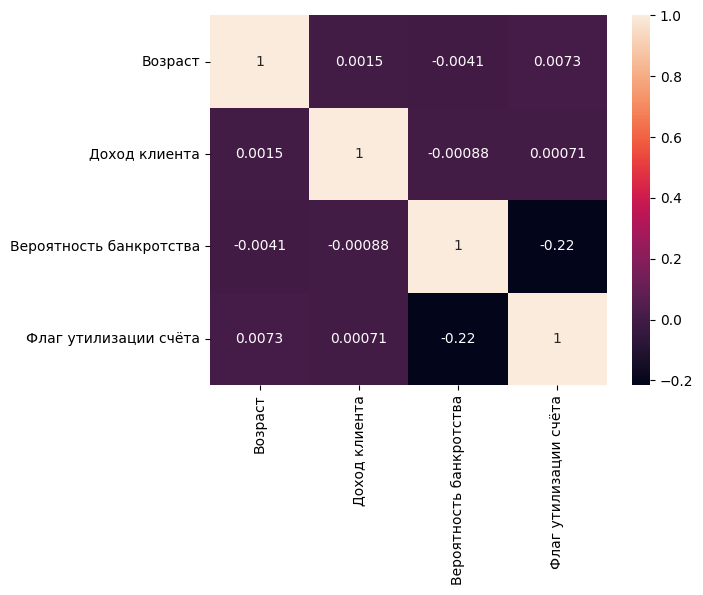

In [8]:
corr_matrix = hist_credit_card[['Возраст', 'Доход клиента', 'Вероятность банкротства', 'Флаг утилизации счёта']].corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

Мы ищем прокси-метрику для нашего теста, соответственно она должна быть однонаправленна с целевой метрикой. Наивысшая положительная корреляция с **Возрастом**. Выберем этот параметр для проверки на гомогенность.

### 4.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

In [58]:
hist_credit_card['Флаг утилизации счёта'].describe()

count    123255.000000
mean          0.741544
std           0.437788
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Флаг утилизации счёта, dtype: float64

##### Расчёт MDE

In [59]:
lift = 0.03
mu = hist_credit_card['Флаг утилизации счёта'].mean()

In [60]:
MDE = lift * mu

In [61]:
MDE

0.02224631860776439

#### Размер выборки

У нас бинарное распределение, односторонняя альтернатива. На исторических данных вычислим вероятность р0 того, что флаг примет значение 1.

In [12]:
p0 = hist_credit_card['Флаг утилизации счёта'].mean()

In [13]:
n = (2 * p0 * (1 - p0) * (norm.ppf(0.95) - norm.ppf(0.15)) ** 2) / MDE ** 2

In [14]:
math.ceil(n)

5569

### 4.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project2_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [15]:
19511

19511

### 5. Проверка на однородность, применение критерия. Принятие решения. Расписать подробно с аргументами.

In [62]:
from google.colab import files
uploaded = files.upload()

Saving Контроль.csv to Контроль (2).csv
Saving Тест.csv to Тест (2).csv


In [63]:
test_group = pd.read_csv(io.BytesIO(uploaded['Тест.csv']))
control_group = pd.read_csv(io.BytesIO(uploaded['Контроль.csv']))

In [64]:
test_group.head(3)

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,18,20855.797437,0.017804,1,193,4969,2818,7594
1,1,69,32627.896361,0.035978,1,2484,5336,2716,5568
2,2,60,27385.898097,0.385621,0,54,0,0,-54


#### Проверка на однородность

Проверим гомогенность наших групп по признаку **возраст**

**H0**: выборки пришли из одного распределения

**H1**: выборки из разных распределений

Будем использовать *критерий Anderson*

In [20]:
from scipy.stats import laplace, norm, ks_2samp, anderson_ksamp, cramervonmises_2samp

In [21]:
x = control_group['Возраст'].copy()
y = test_group['Возраст'].copy()

In [65]:
anderson_ksamp([x, y])

<ipython-input-65-5bacac867c02>:1: UserWarning: p-value capped: true value larger than 0.25
  anderson_ksamp([x, y])


Anderson_ksampResult(statistic=-1.0183622926072189, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.25)

Р-value = более 0.25, что не позволяет отвергнуть нулевую гипотезу при заданном уровне значимости. Соответственно, выборки пришли из одного распределения.

#### Применение критерия

имеем бинарное распределение, попробуем использовать Z-test Фишера в качестве критерия 

In [ ]:
# proportions_ztest ([s1, s2], [n1, n2], alternative = )

In [27]:
s1 = control_group['Флаг утилизации счёта'].sum()
n1 = control_group['Флаг утилизации счёта'].count()
s2 = test_group['Флаг утилизации счёта'].sum()
n2 = test_group['Флаг утилизации счёта'].count()

In [28]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest ([s1, s2], [n1, n2], alternative = 'smaller')

(-0.9961457864657371, 0.15958965800129604)

U-критерий Манна-Уитни

In [33]:
u1, p = mannwhitneyu(control_group['Флаг утилизации счёта'], test_group['Флаг утилизации счёта'], alternative="less")
p

0.1596014652646937

p-value более 15%, это не позволяет отвергнуть нулевую гипотезу о том, что тест и контроль не имеют статзначимых различий..